In [34]:
%%time

# importing necessary dependencies
import json
from datetime import datetime, timedelta
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd
import seaborn
import plotly.express as px
import csv
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from tqdm.notebook import tqdm
import warnings
from IPython.display import clear_output

CPU times: total: 0 ns
Wall time: 0 ns


In [ ]:
%%time
# Code for calculating ESG scores and RRI scores using incidents 

# calculate time weights
n_years = 2
n_days = 365*n_years
curvature_ = 1
weights = np.arange(1,n_days + 1)
weights = weights/weights.max()
weights = ((2**weights) - 1)**curvature_
time_weights = pd.Series(weights)

# calculate raw score for each incident
def get_raw_scores(id_, data, col='score'):
    try:
        incidents = data[data['ISIN'] == id_]
        incidents.set_index('date', inplace=True)
        incident_scores = incidents[col]
        score = incident_scores.rolling(n_days).apply(lambda scores: np.dot(scores, time_weights)).fillna(0)
        return score
    except Exception as e:
        print("error occured", e)

# scale scores
def scale(series, lambda_=0.000105, curvature=5.3):
    return 100*((1 - np.exp(-lambda_*series))**(1/curvature))

scaling = scale(pd.Series(range(750)))
# reduce score importance based on time
def max_decay(series, decay=0.5**(1/365)):
    new_series = pd.Series(index=series.index, dtype="float")
    previous = 0
    for date, value in series.items():
        if previous > 0:
            if value/previous < decay:
                new_series[date] = previous*decay
            else:
                new_series[date] = value
        else:
            new_series[date] = value
            
        previous = new_series[date]
    return new_series

esg_data_spx = {} # store all esg data for stocks
nodata_spx = set()

s = set(incident_data['ISIN']).intersection(all_isinSPX)

for isin in tqdm(all_isinSPX): # for each isin value
    if isin in esg_data_spx:
        continue
    else:
        try:
            scores = incident_data[incident_data['ISIN'] == isin] # find dataset corresponding to isin
            
            esg_metrics = {'ISIN': scores['ISIN'].values, 'date': scores['date'].values, 'price': scores['price'].values} # get isin, date, prices
            
            esgx = ['environmental', 'social', 'governance']
            for subscore in esgx: # calculate each subscore
                scores[subscore + '_score'] = np.where(scores['incident_count'] != 0, scores['score']*scores[subscore]/scores['incident_count'], 0)
                esg_metrics[subscore] = max_decay(scale(get_raw_scores(isin, scores, subscore + '_score'))).values
            esg_metrics['esg_score'] = max_decay(scale(get_raw_scores(isin, incident_data, 'score')))
            esg_data_spx[isin] = pd.DataFrame(esg_metrics) # create dataframe for each subscore
            esg_data_spx[isin].set_index('date', inplace=True)
        except Exception as e:
            print(e)
            print(isin)
            nodata_spx.add(isin)

# isin values for which there is no data
for isin in all_isinSPX:
    if isin not in set(incident_data['ISIN']):
        nodata_spx.add(isin)

In [4]:
%%time
# read datafile that contains all incidents and prices for all isins
incident_data = pd.read_csv("PAPER3_DATA_v1.0.csv", quoting=csv.QUOTE_NONE)

# columns of the dataset
incident_data.columns = ['num', 'ISIN', 'date', 'price', 'ID_RR', 'isBND', 'incident_count', 'unsharp', 
                'severity', 'reach', 'novelty', 'environmental', 'social', 'governance']

for key in ['num', 'ISIN']:
    incident_data[key] = incident_data[key].str.replace('\"', '')

incident_data = incident_data.dropna()

incident_data['date'] = pd.to_datetime(incident_data['date'])

# calculate score
incident_data['score'] = np.where(incident_data['incident_count'] != 0, 
                         10**((incident_data['severity'] / incident_data['incident_count']) - 1) * 
                         (incident_data['reach'] / incident_data['incident_count']) * 
                         (incident_data['novelty'] / incident_data['incident_count']), 
                         0)

# read all constituents in S&P500
spx_const = pd.read_csv("historical.constituents_SPX.csv", quoting=csv.QUOTE_NONE)

spx_const.columns = ["count", "ISIN", "date", "Index_SPX"]
for key in ["count", "ISIN"]:
    spx_const[key] = spx_const[key].str.replace('\"', '')

spx_constituents = {}

# map each date to respective S&P500 constituents
for i in tqdm(range(len(spx_const))):
    row = spx_const.iloc[i]
    if not spx_constituents.get(row['date']):
        spx_constituents[row['date']] = set()
    spx_constituents[row['date']].add(row['ISIN'])

all_isinSPX = set() # set of all isins ever in the S&P500
for date in spx_constituents.keys():
    all_isinSPX = all_isinSPX.union(spx_constituents[date])
all_isinSPX.remove('')

# read stock prices using fundamental data
stock_prices = pd.read_csv("esg_data/spx_TR.CLOSEPRICE.csv", quoting=csv.QUOTE_NONE)

stock_prices.columns = ['num', 'isin', 'close', 'date']

for key in ['num', 'isin', 'close', 'date']:
    stock_prices[key] = stock_prices[key].str.replace('\"', '')
    
stock_prices = stock_prices.replace(r'^\s*$', np.nan, regex=True)
stock_prices = stock_prices.dropna()
stock_prices['close'] =  pd.to_numeric(stock_prices['close'])
stock_prices['date'] = stock_prices['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%dT%H:%M:%SZ'))
stock_prices.set_index('isin', inplace=True)
stock_prices = stock_prices.drop('num', axis=1)

# Convert to a 2D dictionary (isin -> date -> row)
stock_prices['isin2'] = stock_prices.index
stock_prices = stock_prices.groupby('isin2').apply(
    lambda x: x.set_index('date').drop(columns='isin2').to_dict('index')
).to_dict()


# read already stored esg data for equities
with open('data.json') as json_file:
    esg_data_spx = json.load(json_file)

for isin in tqdm(esg_data_spx):
    esg_data_spx[isin] = pd.DataFrame.from_dict(esg_data_spx[isin])

# sector data
sector_data = pd.read_csv("SPsectors.csv", quoting=csv.QUOTE_NONE)
spx_sector = {sector_data['ISIN'].iloc[i]: sector_data['SP_sectors'].iloc[i] for i in range(len(sector_data))}

<timed exec>:2: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
100%|██████████████████████████████████████████████████████████████████████████████████| 4962660/4962660 [05:45<00:00, 14349.74it/s]
<timed exec>:60: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
100%|██████████████████████████████████████████████████████████████████████████████████████████| 1197/1197 [00:06<00:00, 185.72it/s]


CPU times: total: 8min 16s
Wall time: 12min 19s


In [5]:
# isin values for which there is no given sector
no_sectors = set()
for isin in all_isinSPX:
    if spx_sector.get(isin, 'random') not in ['communications', 'consumer_discretionary', 'consumer_staples', 'energy', 'financials', 'health_care', 'industrials', 'information_technology', 'materials',  'real_estate', 'utilities']:
        no_sectors.add(isin)
print(f"There are {len(no_sectors)} companies with no assigned sector.")

There are 180 companies with no assigned sector.


100%|████████████████████████████████████████████████████████████████████████████████████████████| 511/511 [00:00<00:00, 744.09it/s]




ESG scores for equities distribution on 2021-01-03:


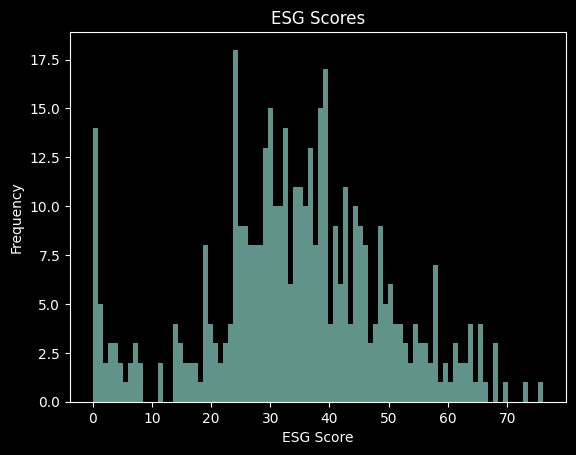

Total count: 437
Standard deviation: 15.41
Max score: 76.13
Median: 34.87
Mean (Excluding 0): 35.72
Q1: 25.92
Q3: 44.23
IQR: 18.31


In [6]:

# check if there are any isins for which there is no data for a given date
date = '2021-01-03'
date2 = date.replace('-', '/')
scores = []
dates = []
companies = []
na = set()
for isin in tqdm(spx_constituents[date]):
    try:
        scores.append([esg_data_spx[isin][esg_data_spx[isin].index > date2]['esg_score'].iloc[0], isin])
        dates.append(esg_data_spx[isin][esg_data_spx[isin].index > date2].index[0])
        companies.append(isin)
    except Exception:
        na.add(isin)
scores.sort()


plt.style.use('dark_background') # plot distribution of ESG scores for given date

print(f"\n\nESG scores for equities distribution on {date}:")
n, bins, patches = plt.hist([x[0] for x in scores], bins=90, linewidth=0.5, alpha=0.7)
plt.title('ESG Scores', fontsize=12)
plt.xlabel('ESG Score', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.show()

# descriptive statistics for distribution
arr = np.array([x[0] for x in scores])
print(f"Total count: {len(scores)}")
print(f"Standard deviation: {round(np.std(arr), 2)}")
print(f"Max score: {round(max(arr), 2)}")
print(f"Median: {round(np.median(arr), 2)}")
print(f"Mean (Excluding 0): {round(arr[arr != 0].mean(), 2)}")
print(f"Q1: {round(np.percentile(arr, 25), 2)}")
print(f"Q3: {round(np.percentile(arr, 75), 2)}")
print(f"IQR: {round(np.subtract(*np.percentile(arr, [75, 25])), 2)}")

In [7]:
# dates to start tracking from 2022-03-19 to 15 years back weekly on wednesday
datelist = [datetime.strptime('2022-03-16', '%Y-%m-%d') - timedelta(days=x*7) for x in range(780)]
datelist.reverse()

no_data = {}  # ISIN from S&P500 for which no data is available
sp500_data = {}  # S&P500 Data with ESG scores for which is available

for date_obj in tqdm(datelist):
    date = date_obj.strftime('%Y/%m/%d')
    no_data[date] = set()
    sp500_data[date] = {}
    for isin in spx_constituents[date.replace('/', '-')]:
        try:
            if not esg_data_spx[isin][esg_data_spx[isin].index == date].empty:
                sp500_data[date][isin] = esg_data_spx[isin][esg_data_spx[isin].index == date].copy()
                try:
                    # Replace prices with fundamental data prices from Marc Weibel
                    price = stock_prices.loc[(stock_prices.index == isin) & (stock_prices['date'] == pd.to_datetime(date)), 'close'].values[0]
                    sp500_data[date][isin].loc[:, 'price'] = price
                except Exception:
                    pass
            else:
                no_data[date].add(isin)
        except Exception:
            no_data[date].add(isin)


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 780/780 [07:16<00:00,  1.79it/s]


In [85]:
print(esg_data_spx['US88160R1014'][-361:-359]) # Prices are not adjusted for splits? TSLA split was later though
print('\nUsing Fundamental Data:\n')
print(pd.DataFrame(stock_prices['US88160R1014']).transpose()['close'][-484:-482])

                    ISIN       price  environmental     social  governance  \
2022/05/20  US88160R1014  442.599889      43.749010  59.194743   46.811620   
2022/05/23  US88160R1014  224.966442      43.723339  59.164048   46.782111   

            esg_score  
2022/05/20  62.881388  
2022/05/23  62.848611  

Using Fundamental Data:

2022-05-20    221.299779
2022-05-23    224.966442
Name: close, dtype: float64


  0%|                                                                                                       | 0/780 [00:00<?, ?it/s]C:\Users\anish\AppData\Local\Temp\ipykernel_74540\247284300.py:52: FutureWarning: Series.bool is now deprecated and will be removed in future version of pandas
  elif (sp500_data[date][isin][metric] > THRESHOLD).bool(): # if esg metric is greater than threshold add it to non esg portfolios
C:\Users\anish\AppData\Local\Temp\ipykernel_74540\247284300.py:55: FutureWarning: Series.bool is now deprecated and will be removed in future version of pandas
  elif (sp500_data[date][isin][metric] == 0).bool(): # if esg metric is zero add to non_esg_zero portfolio
C:\Users\anish\AppData\Local\Temp\ipykernel_74540\247284300.py:41: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  portfolios[x]['account_value'] += float(portfolios[x]['holdings'][isin] * esg_data_spx[isin][esg_d

<Figure size 640x480 with 0 Axes>

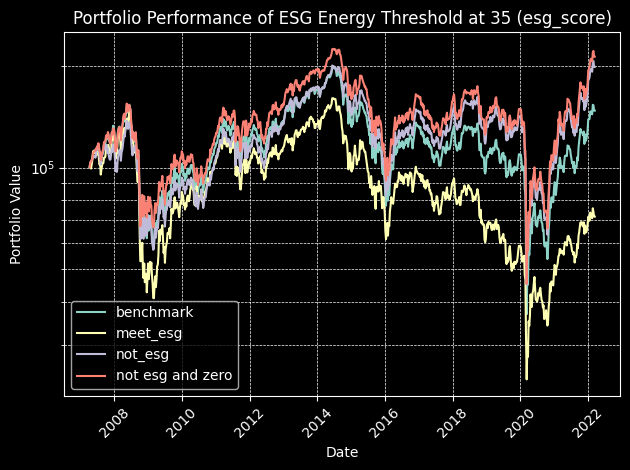


ESG Portfolio Metrics
Sharpe Ratio: 0.116
Average Return (Per Annum): 0.978
Final Value: 71628.187


Non-ESG Portfolio Metrics
Sharpe Ratio: 0.309
Average Return (Per Annum): 1.046
Final Value: 198411.919


Non-ESG/0-RRI Portfolio Metrics
Sharpe Ratio: 0.325
Average Return (Per Annum): 1.051
Final Value: 212658.748


Benchmark Portfolio Metrics
Sharpe Ratio: 0.253
Average Return (Per Annum): 1.026
Final Value: 147315.068



  0%|                                                                                                       | 0/780 [00:00<?, ?it/s]C:\Users\anish\AppData\Local\Temp\ipykernel_74540\247284300.py:52: FutureWarning: Series.bool is now deprecated and will be removed in future version of pandas
  elif (sp500_data[date][isin][metric] > THRESHOLD).bool(): # if esg metric is greater than threshold add it to non esg portfolios
C:\Users\anish\AppData\Local\Temp\ipykernel_74540\247284300.py:55: FutureWarning: Series.bool is now deprecated and will be removed in future version of pandas
  elif (sp500_data[date][isin][metric] == 0).bool(): # if esg metric is zero add to non_esg_zero portfolio
C:\Users\anish\AppData\Local\Temp\ipykernel_74540\247284300.py:41: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  portfolios[x]['account_value'] += float(portfolios[x]['holdings'][isin] * esg_data_spx[isin][esg_d

<Figure size 640x480 with 0 Axes>

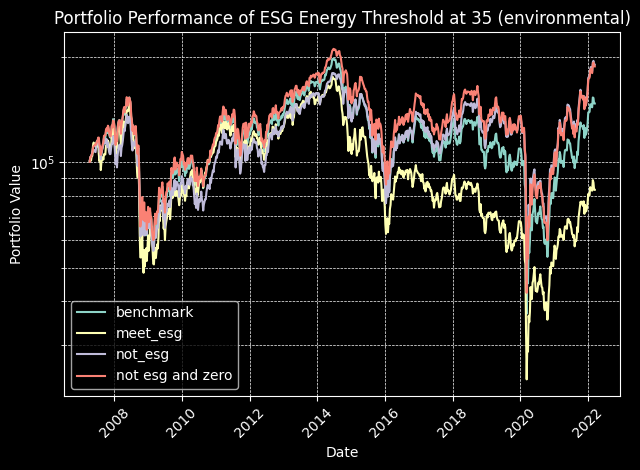


ESG Portfolio Metrics
Sharpe Ratio: 0.146
Average Return (Per Annum): 0.987
Final Value: 83439.623


Non-ESG Portfolio Metrics
Sharpe Ratio: 0.299
Average Return (Per Annum): 1.043
Final Value: 190245.207


Non-ESG/0-RRI Portfolio Metrics
Sharpe Ratio: 0.302
Average Return (Per Annum): 1.043
Final Value: 188111.367


Benchmark Portfolio Metrics
Sharpe Ratio: 0.253
Average Return (Per Annum): 1.026
Final Value: 147315.068



  0%|                                                                                                       | 0/780 [00:00<?, ?it/s]C:\Users\anish\AppData\Local\Temp\ipykernel_74540\247284300.py:52: FutureWarning: Series.bool is now deprecated and will be removed in future version of pandas
  elif (sp500_data[date][isin][metric] > THRESHOLD).bool(): # if esg metric is greater than threshold add it to non esg portfolios
C:\Users\anish\AppData\Local\Temp\ipykernel_74540\247284300.py:55: FutureWarning: Series.bool is now deprecated and will be removed in future version of pandas
  elif (sp500_data[date][isin][metric] == 0).bool(): # if esg metric is zero add to non_esg_zero portfolio
C:\Users\anish\AppData\Local\Temp\ipykernel_74540\247284300.py:41: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  portfolios[x]['account_value'] += float(portfolios[x]['holdings'][isin] * esg_data_spx[isin][esg_d

<Figure size 640x480 with 0 Axes>

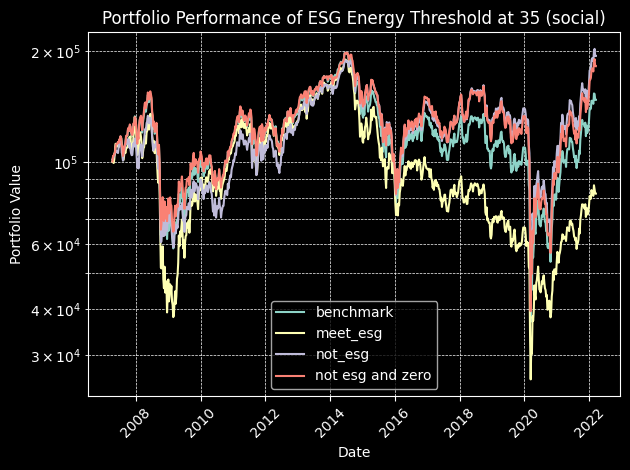


ESG Portfolio Metrics
Sharpe Ratio: 0.144
Average Return (Per Annum): 0.987
Final Value: 82080.262


Non-ESG Portfolio Metrics
Sharpe Ratio: 0.304
Average Return (Per Annum): 1.044
Final Value: 193716.89


Non-ESG/0-RRI Portfolio Metrics
Sharpe Ratio: 0.297
Average Return (Per Annum): 1.04
Final Value: 181712.454


Benchmark Portfolio Metrics
Sharpe Ratio: 0.253
Average Return (Per Annum): 1.026
Final Value: 147315.068



  0%|                                                                                                       | 0/780 [00:00<?, ?it/s]C:\Users\anish\AppData\Local\Temp\ipykernel_74540\247284300.py:52: FutureWarning: Series.bool is now deprecated and will be removed in future version of pandas
  elif (sp500_data[date][isin][metric] > THRESHOLD).bool(): # if esg metric is greater than threshold add it to non esg portfolios
C:\Users\anish\AppData\Local\Temp\ipykernel_74540\247284300.py:55: FutureWarning: Series.bool is now deprecated and will be removed in future version of pandas
  elif (sp500_data[date][isin][metric] == 0).bool(): # if esg metric is zero add to non_esg_zero portfolio
C:\Users\anish\AppData\Local\Temp\ipykernel_74540\247284300.py:41: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  portfolios[x]['account_value'] += float(portfolios[x]['holdings'][isin] * esg_data_spx[isin][esg_d

<Figure size 640x480 with 0 Axes>

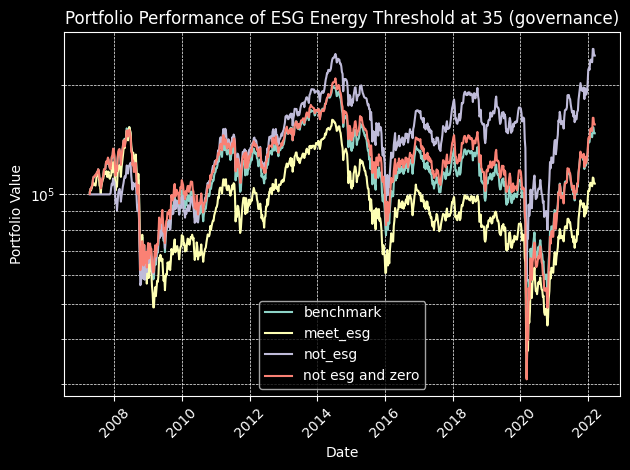


ESG Portfolio Metrics
Sharpe Ratio: 0.187
Average Return (Per Annum): 1.004
Final Value: 107071.41


Non-ESG Portfolio Metrics
Sharpe Ratio: 0.348
Average Return (Per Annum): 1.06
Final Value: 241240.437


Non-ESG/0-RRI Portfolio Metrics
Sharpe Ratio: 0.272
Average Return (Per Annum): 1.03
Final Value: 155848.366


Benchmark Portfolio Metrics
Sharpe Ratio: 0.253
Average Return (Per Annum): 1.026
Final Value: 147315.068



In [38]:
datelist = [datetime.strptime('2022-03-16', '%Y-%m-%d') - timedelta(days=x*7) for x in range(780)]
datelist.reverse()

THRESHOLD = 35 # fixed threshold for RRI score
PERCENTILE = 0.3 # top 30 percent companies in terms of ESG performance

# spx sectors
SECTORS = ['communications', 'consumer_discretionary', 'consumer_staples', 'energy', 'financials', 'health_care', 
           'industrials', 'information_technology', 'materials',  'real_estate', 'utilities']

# which metric to look at
METRICS = ['esg_score', 'environmental', 'social', 'governance']

# meet_esg - companies meeting esg criteria and RRI not zero
# not_esg - companies not meeting esg criteria and RRI not zero
# not_esg_zero - not_esg + companies with rri of 0
OPTIONS = ['meet_esg', 'not_esg', 'not_esg_zero', 'benchmark']


# all isins in specific sector in S&P500 for given date
def generate_isin(date, sector=False):
    if not sector: # if no sector return everything
        return sp500_Data[date]
    isin_values = set()
    for isin in sp500_data[date]:
        if spx_sector.get(isin, '') == sector:
            isin_values.add(isin)
    return isin_values

for metric in METRICS:
    portfolios = {x: {'account_value': 100000, 'holdings': {}, 'history': []} for x in OPTIONS}

    for i in tqdm(range(len(datelist))):
        # parse current date
        date = datelist[i].strftime('%Y/%m/%d') 
    
        # sell all holdings of current date for each portfolio
        for x in OPTIONS:
            # sell each holding at last available price
            for isin in portfolios[x]['holdings']:
                portfolios[x]['account_value'] += float(portfolios[x]['holdings'][isin] * stock_prices[isin][pd.to_datetime(date)]['close'])
            
            # clear all holdings
            portfolios[x]['holdings'] = {}
            
            # add new value to portfolio history
            portfolios[x]['history'].append(portfolios[x]['account_value'])
            
        for isin in generate_isin(date, 'energy'): # generate all isins to consider investing
            if sp500_data[date][isin].empty: # if no data ignore
                continue
            elif (sp500_data[date][isin][metric] > THRESHOLD).bool(): # if esg metric is greater than threshold add it to non esg portfolios
                portfolios['not_esg']['holdings'][isin] = 0
                portfolios['not_esg_zero']['holdings'][isin] = 0
            elif (sp500_data[date][isin][metric] == 0).bool(): # if esg metric is zero add to non_esg_zero portfolio
                portfolios['not_esg_zero']['holdings'][isin] = 0
            else: # add other investments to portfolio that meets esg metric requirements
                portfolios['meet_esg']['holdings'][isin] = 0
            portfolios['benchmark']['holdings'][isin] = 0 # benchmark portfolio
    
        for x in OPTIONS:
            cnt = len(portfolios[x]['holdings']) # number of holdings 
            if cnt == 0: continue
            val = portfolios[x]['account_value'] / cnt # value allocated to each investment // CURRENTLY USING EQUAL WEIGHTED WILL CHANGE TO MARKET CAP TOO
            
            # determine number of shares for each isin
            for isin in portfolios[x]['holdings']:
                portfolios[x]['holdings'][isin] = val/sp500_data[date][isin]['price']
                portfolios[x]['account_value'] -= val
    
    # sell everything at the end
    for x in OPTIONS:
        # sell each holding at last available price
        for isin in portfolios[x]['holdings']:
            portfolios[x]['account_value'] += float(portfolios[x]['holdings'][isin] * stock_prices[isin][pd.to_datetime(date)]['close'])
        
        # clear all holdings
        portfolios[x]['holdings'] = {}
        
        # add new value to portfolio history
        portfolios[x]['history'].append(portfolios[x]['account_value'])
        portfolios[x]['history'] = portfolios[x]['history'][1:]
    
    # Set dark theme
    plt.clf()
    plt.style.use('dark_background')
    fig, ax = plt.subplots()
    
    # Plot data
    ax.plot(datelist, portfolios['benchmark']['history'], label='benchmark', linestyle='-')
    ax.plot(datelist, portfolios['meet_esg']['history'], label='meet_esg', linestyle='-')
    ax.plot(datelist, portfolios['not_esg']['history'], label='not_esg', linestyle='-')
    ax.plot(datelist, portfolios['not_esg_zero']['history'], label='not esg and zero', linestyle='-')
    ax.set_xlabel('Date')
    ax.set_ylabel('Portfolio Value')
    ax.set_title(f'Portfolio Performance of ESG Energy Threshold at 35 ({metric})')
    plt.yscale("log")   
    plt.xticks(rotation=45)
    ax.legend()
    ax.grid(True, which="both", linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()
    
    def rd(x):
        return round(x, 3) 
        
    # Calculate sharpe ratio and returns
    def portfolioMetrics(history):
        returns = np.array([(history[i] - history[i - 1])/history[i - 1] for i in range(1, len(history))])
        mean = returns.mean()*52
        std = returns.std() * np.sqrt(52)
        print(f"Sharpe Ratio: {rd(mean/std)}")
        print(f"Average Return (Per Annum): {rd(((history[-1]/history[0])**(1/len(history)))**52)}")
        print(f"Final Value: {rd(history[-1])}\n")
    
    # Display Metrics
    print("\n\033[4mESG Portfolio Metrics\033[0m")
    portfolioMetrics(portfolios['meet_esg']['history'])
    print("\n\033[4mNon-ESG Portfolio Metrics\033[0m")
    portfolioMetrics(portfolios['not_esg']['history'])
    print("\n\033[4mNon-ESG/0-RRI Portfolio Metrics\033[0m")
    portfolioMetrics(portfolios['not_esg_zero']['history'])
    print("\n\033[4mBenchmark Portfolio Metrics\033[0m")
    portfolioMetrics(portfolios['benchmark']['history'])

  0%|                                                                                                       | 0/780 [00:00<?, ?it/s]C:\Users\anish\AppData\Local\Temp\ipykernel_74540\1343075271.py:10: FutureWarning: Series.bool is now deprecated and will be removed in future version of pandas
  if (sp500_data[date][isin]['environmental'] > 0).bool() and (sp500_data[date][isin]['social'] > 0).bool() and (sp500_data[date][isin]['governance'] > 0).bool():
100%|█████████████████████████████████████████████████████████████████████████████████████████████| 780/780 [01:07<00:00, 11.55it/s]


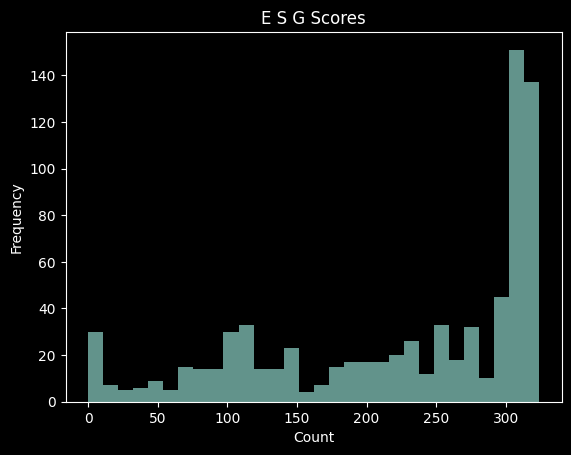

  0%|                                                                                                       | 0/780 [00:00<?, ?it/s]C:\Users\anish\AppData\Local\Temp\ipykernel_74540\1343075271.py:29: FutureWarning: Series.bool is now deprecated and will be removed in future version of pandas
  if (sp500_data[date][isin]['environmental'] > 0).bool() and (sp500_data[date][isin]['social'] > 0).bool():
100%|█████████████████████████████████████████████████████████████████████████████████████████████| 780/780 [00:45<00:00, 17.23it/s]


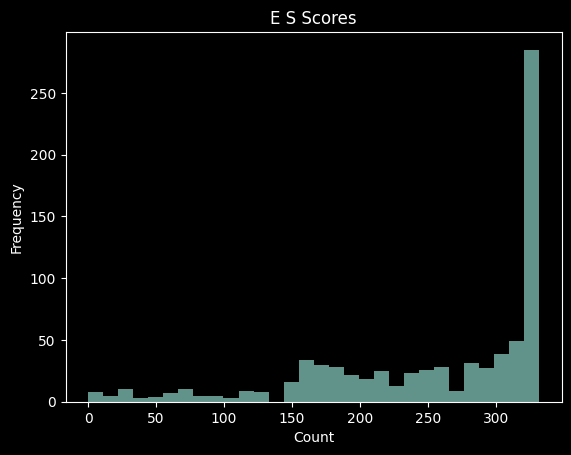

  0%|                                                                                                       | 0/780 [00:00<?, ?it/s]C:\Users\anish\AppData\Local\Temp\ipykernel_74540\1343075271.py:47: FutureWarning: Series.bool is now deprecated and will be removed in future version of pandas
  if (sp500_data[date][isin]['environmental'] > 0).bool() and (sp500_data[date][isin]['governance'] > 0).bool():
100%|█████████████████████████████████████████████████████████████████████████████████████████████| 780/780 [00:48<00:00, 16.19it/s]


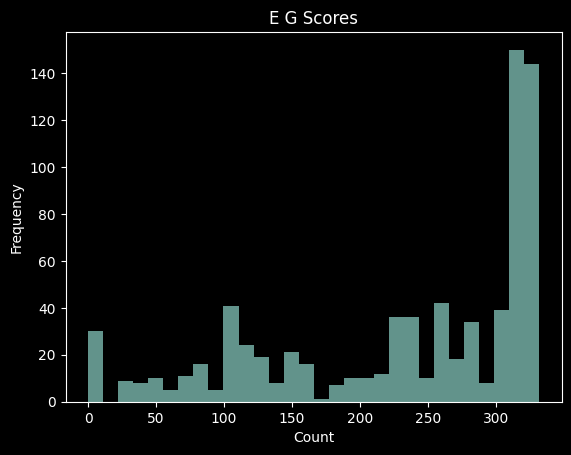

  0%|                                                                                                       | 0/780 [00:00<?, ?it/s]C:\Users\anish\AppData\Local\Temp\ipykernel_74540\1343075271.py:65: FutureWarning: Series.bool is now deprecated and will be removed in future version of pandas
  if (sp500_data[date][isin]['governance'] > 0).bool() and (sp500_data[date][isin]['social'] > 0).bool():
100%|█████████████████████████████████████████████████████████████████████████████████████████████| 780/780 [00:51<00:00, 15.13it/s]


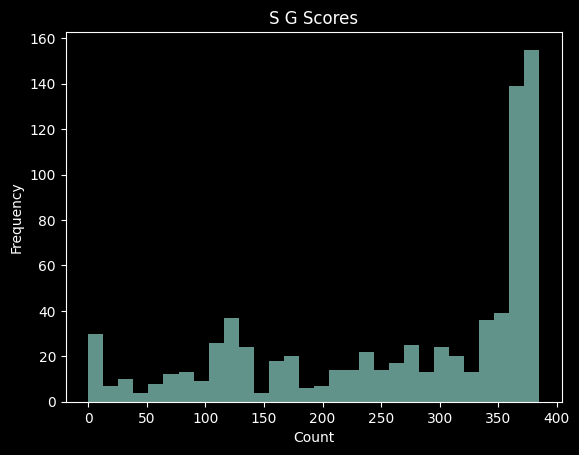

  0%|                                                                                                       | 0/780 [00:00<?, ?it/s]C:\Users\anish\AppData\Local\Temp\ipykernel_74540\1343075271.py:83: FutureWarning: Series.bool is now deprecated and will be removed in future version of pandas
  if (sp500_data[date][isin]['environmental'] > 0).bool():
100%|█████████████████████████████████████████████████████████████████████████████████████████████| 780/780 [00:32<00:00, 24.28it/s]


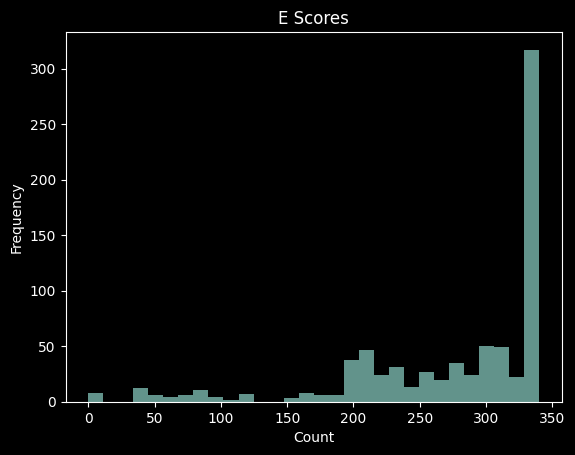

  0%|                                                                                                       | 0/780 [00:00<?, ?it/s]C:\Users\anish\AppData\Local\Temp\ipykernel_74540\1343075271.py:101: FutureWarning: Series.bool is now deprecated and will be removed in future version of pandas
  if (sp500_data[date][isin]['social'] > 0).bool():
100%|█████████████████████████████████████████████████████████████████████████████████████████████| 780/780 [00:32<00:00, 23.95it/s]


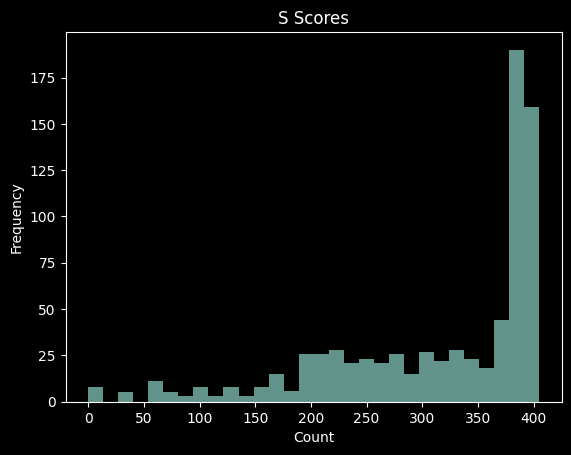

  0%|                                                                                                       | 0/780 [00:00<?, ?it/s]C:\Users\anish\AppData\Local\Temp\ipykernel_74540\1343075271.py:119: FutureWarning: Series.bool is now deprecated and will be removed in future version of pandas
  if (sp500_data[date][isin]['governance'] > 0).bool():
100%|█████████████████████████████████████████████████████████████████████████████████████████████| 780/780 [00:42<00:00, 18.55it/s]


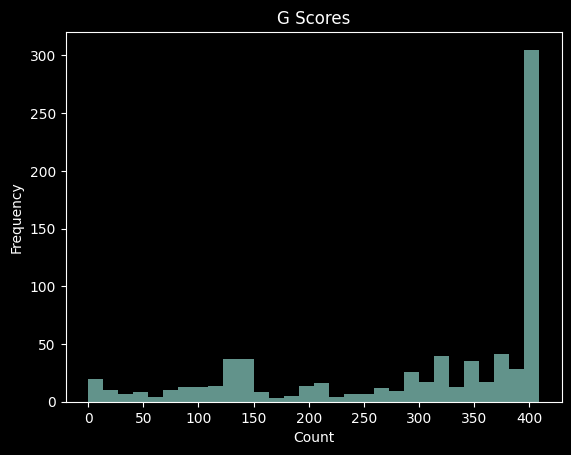

In [104]:
# counts of companies out of 500 who have an ESG score of more than 0
counts = []
for i in tqdm(range(len(datelist))):
    # parse current date
    date = datelist[i].strftime('%Y/%m/%d') 
    cnt = 0
    for isin in generate_isin(date): # generate all isins to consider investing
        if sp500_data[date][isin].empty: # if no data ignore
            continue
        if (sp500_data[date][isin]['environmental'] > 0).bool() and (sp500_data[date][isin]['social'] > 0).bool() and (sp500_data[date][isin]['governance'] > 0).bool():
            cnt += 1
    counts.append(cnt)

n, bins, patches = plt.hist(counts, bins=30, linewidth=0.5, alpha=0.7)
plt.title('E S G Scores', fontsize=12)
plt.xlabel('Count', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.show()

# counts of companies out of 500 who have an ESG score of more than 0
counts = []
for i in tqdm(range(len(datelist))):
    # parse current date
    date = datelist[i].strftime('%Y/%m/%d') 
    cnt = 0
    for isin in generate_isin(date): # generate all isins to consider investing
        if sp500_data[date][isin].empty: # if no data ignore
            continue
        if (sp500_data[date][isin]['environmental'] > 0).bool() and (sp500_data[date][isin]['social'] > 0).bool():
            cnt += 1
    counts.append(cnt)

n, bins, patches = plt.hist(counts, bins=30, linewidth=0.5, alpha=0.7)
plt.title('E S Scores', fontsize=12)
plt.xlabel('Count', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.show()

counts = []
for i in tqdm(range(len(datelist))):
    # parse current date
    date = datelist[i].strftime('%Y/%m/%d') 
    cnt = 0
    for isin in generate_isin(date): # generate all isins to consider investing
        if sp500_data[date][isin].empty: # if no data ignore
            continue
        if (sp500_data[date][isin]['environmental'] > 0).bool() and (sp500_data[date][isin]['governance'] > 0).bool():
            cnt += 1
    counts.append(cnt)

n, bins, patches = plt.hist(counts, bins=30, linewidth=0.5, alpha=0.7)
plt.title('E G Scores', fontsize=12)
plt.xlabel('Count', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.show()

counts = []
for i in tqdm(range(len(datelist))):
    # parse current date
    date = datelist[i].strftime('%Y/%m/%d') 
    cnt = 0
    for isin in generate_isin(date): # generate all isins to consider investing
        if sp500_data[date][isin].empty: # if no data ignore
            continue
        if (sp500_data[date][isin]['governance'] > 0).bool() and (sp500_data[date][isin]['social'] > 0).bool():
            cnt += 1
    counts.append(cnt)

n, bins, patches = plt.hist(counts, bins=30, linewidth=0.5, alpha=0.7)
plt.title('S G Scores', fontsize=12)
plt.xlabel('Count', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.show()

counts = []
for i in tqdm(range(len(datelist))):
    # parse current date
    date = datelist[i].strftime('%Y/%m/%d') 
    cnt = 0
    for isin in generate_isin(date): # generate all isins to consider investing
        if sp500_data[date][isin].empty: # if no data ignore
            continue
        if (sp500_data[date][isin]['environmental'] > 0).bool():
            cnt += 1
    counts.append(cnt)

n, bins, patches = plt.hist(counts, bins=30, linewidth=0.5, alpha=0.7)
plt.title('E Scores', fontsize=12)
plt.xlabel('Count', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.show()

counts = []
for i in tqdm(range(len(datelist))):
    # parse current date
    date = datelist[i].strftime('%Y/%m/%d') 
    cnt = 0
    for isin in generate_isin(date): # generate all isins to consider investing
        if sp500_data[date][isin].empty: # if no data ignore
            continue
        if (sp500_data[date][isin]['social'] > 0).bool():
            cnt += 1
    counts.append(cnt)

n, bins, patches = plt.hist(counts, bins=30, linewidth=0.5, alpha=0.7)
plt.title('S Scores', fontsize=12)
plt.xlabel('Count', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.show()

counts = []
for i in tqdm(range(len(datelist))):
    # parse current date
    date = datelist[i].strftime('%Y/%m/%d') 
    cnt = 0
    for isin in generate_isin(date): # generate all isins to consider investing
        if sp500_data[date][isin].empty: # if no data ignore
            continue
        if (sp500_data[date][isin]['governance'] > 0).bool():
            cnt += 1
    counts.append(cnt)

n, bins, patches = plt.hist(counts, bins=30, linewidth=0.5, alpha=0.7)
plt.title('G Scores', fontsize=12)
plt.xlabel('Count', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.show()